# NEON

This notebook is an excercise in executing ISOFIT on two dates from the NEON dataset and interpreting the outputs of ISOFIT. 

In [12]:
# Jupyter magics
%matplotlib inline

# Setup logging
import logging
import os

from pathlib import Path

# Enable the ISOFIT logger
logging.getLogger().setLevel(logging.INFO)

# This tutorial assumes this notebook is executed inside the official ISOFIT docker
home = Path('/home/ray')

## Setup

The NEON dataset is structured as the following:
```
├── FieldSpectrometer
│   ├── BlackTarp01
│   │   ├── Data
│   │   │   ├── BlackTarp01_IndScienceSpectra.dat
│   │   │   ├── BlackTarp01_PanelBRDF.dat
│   │   │   ├── BlackTarp01_PanelSpectra.dat
│   │   │   ├── BlackTarp01_RadTrace.dat
│   │   │   ├── BlackTarp01_Refl.dat
│   │   │   ├── BlackTarp01_ScienceSpectra.dat
│   │   │   └── BlackTarp01_optNum.dat
│   │   └── Plot
│   │       ├── 01_BlackTarp01_optNum.png
│   │       ├── 02_BlackTarp01_RadTrace.png
│   │       ├── 03_BlackTarp01_PanelBRDF.png
│   │       ├── 04_BlackTarp01_PanelSpectra.png
│   │       ├── 05_BlackTarp01_ScienceSpectra.png
│   │       └── 06_BlackTarp01_Refl.png
│   ├── BlackTarp02
│   │   └── ... [trimmed]
│   └── ... [trimmed]
├── Radiance
│   ├── NIS01_20210403_173647_obs_ort
│   ├── NIS01_20210403_173647_obs_ort.hdr
│   ├── NIS01_20210403_173647_rdn_ort
│   ├── NIS01_20210403_173647_rdn_ort.hdr
│   ├── NIS01_20210403_174150_obs_ort
│   ├── NIS01_20210403_174150_obs_ort.hdr
│   ├── NIS01_20210403_174150_rdn_ort
│   └── NIS01_20210403_174150_rdn_ort.hdr
├── Reflectance
│   ├── NIS01_20210403_173647_rdn_ort_atm_nodata.bsq
│   ├── NIS01_20210403_173647_rdn_ort_atm_nodata.hdr
│   ├── NIS01_20210403_174150_rdn_ort_atm_nodata.bsq
│   └── NIS01_20210403_174150_rdn_ort_atm_nodata.hdr
└── Report
    └── 20210403_R10E_P1C2_TBMT_VicariousCalibration_Report.pdf
```

ISOFIT needs at minimum three pieces as input:

    1. Radiance measurements (rdn)
    2. Observation values    (obs)
    3. Location information  (loc)

NEON provides the RDN and OBS files for two dates:

```
Radiance
├── 173647
│   ├── NIS01_20210403_173647_obs_ort
│   ├── NIS01_20210403_173647_obs_ort.hdr
│   ├── NIS01_20210403_173647_rdn_ort
│   └── NIS01_20210403_173647_rdn_ort.hdr
└── 174150
    ├── NIS01_20210403_174150_obs_ort
    ├── NIS01_20210403_174150_obs_ort.hdr
    ├── NIS01_20210403_174150_rdn_ort
    └── NIS01_20210403_174150_rdn_ort.hdr
```

As such, the LOC file needs to be generated or faked. 


In [2]:
import numpy as np

# Extract the image locations of each point of interest (POI)
# These are defined in the NEON report as pixel locations, so we round here to convert to indices
report = {}
report['173647'] = {           # Upp L Y  | Low R Y  | Upp L X | Low R X
    'WhiteTarp': np.round([2224.9626, 2230.9771, 316.0078, 324.9385,]).astype(int),
    'BlackTarp': np.round([2224.9626, 2231.0032, 328.0086, 333.9731,]).astype(int),
    'Veg'      : np.round([2245.0381, 2258.8103, 343.9006, 346.9423,]).astype(int),
    'EWRoad'   : np.round([2214.9905, 2216.9978, 348.9902, 373.0080,]).astype(int),
    'NSRoad'   : np.round([2205.9580, 2225.9612, 357.9536, 359.9608,]).astype(int)
}
report['174150'] = {           # Upp L Y | Low R Y | Upp L X  | Low R X
    'WhiteTarp': np.round([653.9626, 659.9771, 3143.0078, 3151.9385]).astype(int),
    'BlackTarp': np.round([653.9626, 660.0032, 3155.0086, 3160.9731]).astype(int),
    'Veg'      : np.round([674.0381, 687.8103, 3170.9006, 3173.9423]).astype(int),
    'EWRoad'   : np.round([643.9905, 645.9978, 3175.9902, 3200.0080]).astype(int),
    'NSRoad'   : np.round([634.9580, 654.9612, 3184.9536, 3186.9608]).astype(int)
}
# Converts numpy array to comma-separated string for ISOFIT
toString = lambda array: ', '.join(str(v) for v in array)

In [3]:
# Which NEON date to process - change this to process a different date
neon_id = list(report.keys())[0]

# Select the locations from the neon id -- roi == Regions of Interest
roi = report[neon_id]

# Path to the input NEON data
indata = home/'isofit/.idea/neon/data/TableMountainCalibration/Radiance'

# Path to write isofit output
output = home/'tutorials/isotuts/NEON/'

In [4]:
from isotuts.utils import fakeLOC

fakeLOC(
    rdn = str(indata/f'NIS01_20210403_{neon_id}_rdn_ort.hdr'),
    lon = -105.237000,
    lat = 40.125000,
    elv = 1689.0
)

Key 'band names' not found in the metadata, skipping


# Apply OE

The next part walks through running the ISOFIT utility script `isofit/utils/apply_oe.py`. This is the first step of executing ISOFIT and will generate a default configuration.

In [5]:
# If running inside the Docker, this is already set. You may need to point this to your sRTMnet installation path.
if not os.environ.get('EMULATOR_PATH'):
    os.environ['EMULATOR_PATH'] = str(home/'sRTMnet_v100/sRTMnet_v100')

if not os.environ.get('SIXS_DIR'):
    os.environ['SIXS_DIR'] = str(home/'6sv-2.1')

In [6]:
from isofit.utils.apply_oe import _cli as apply_oe

try:
    apply_oe([
        str(indata/f'NIS01_20210403_{neon_id}_rdn_ort'), # Radiance
        str(indata/f'NIS01_20210403_{neon_id}_loc_ort'), # Location
        str(indata/f'NIS01_20210403_{neon_id}_obs_ort'), # Observations
        str(output), # Output directory
        'neon', # Sensor
        '--emulator_base', os.environ['EMULATOR_PATH'],
        '--n_cores', str(os.cpu_count()),
        # '--presolve', '1',
        # '--debug-args' # Uncomment to see all of the arguments apply_oe will execute with
    ])
except FileNotFoundError as e:
    print(f'Assuming the file not found error is the surface.mat, continue to the next block: {e}')

##
"template_construction.py"

/home/ray/anaconda3/envs/isofit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:2023-08-17,12:28:42 ||| namespace(emulator_base='/home/ray/sRTMnet_v100/sRTMnet_v100', n_cores=8, input_radiance='/home/ray/isofit/.idea/neon/data/TableMountainCalibration/Radiance/NIS01_20210403_173647_rdn_ort', input_loc='/home/ray/isofit/.idea/neon/data/TableMountainCalibration/Radiance/NIS01_20210403_173647_loc_ort', input_obs='/home/ray/isofit/.idea/neon/data/TableMountainCalibration/Radiance/NIS01_20210403_173647_obs_ort', working_directory='/home/ray/tutorials/isotuts/NEON', sensor='neon', copy_input_files=False, modtran_path=None, wavelength_path=None, surface_category='multicomponent_surface', aerosol_climatology_path=None, rdn_factors_path=None, surface_path=None, atmosphere_type='ATM_MIDLAT_SUMMER', channeliz

(spawn_rt pid=9649) bash /home/ray/tutorials/isotuts/NEON/lut_full/LUT_AOT550-0.0010_H2OSTR-0.0500_OBSZEN-170.2112_TRUEAZ-91.2229.sh
(spawn_rt pid=9650) bash /home/ray/tutorials/isotuts/NEON/lut_full/LUT_AOT550-0.0010_H2OSTR-0.0500_OBSZEN-179.9987_TRUEAZ-342.1401.sh [repeated 17x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(spawn_rt pid=9650) bash /home/ray/tutorials/isotuts/NEON/lut_full/LUT_AOT550-0.1009_H2OSTR-0.0500_OBSZEN-179.9987_TRUEAZ-166.2780.sh [repeated 15x across cluster]
(spawn_rt pid=9649) bash /home/ray/tutorials/isotuts/NEON/lut_full/LUT_AOT550-0.2008_H2OSTR-0.0500_OBSZEN-179.9987_TRUEAZ-101.5940.sh [repeated 17x across cluster]
(spawn_rt pid=9650) bash /home/ray/tutorials/isotuts/NEON/lut_full/LUT_AOT550-0.3007_H2OSTR-0.0500_OBSZEN-170.2112_TRUEAZ-101.5940.sh [repeated 12x across cluster]
(spawn_rt pid=96

INFO:2023-08-17,12:56:12 ||| loading 6s results for emulator


130/130 [==============================] - 10s 71ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/home/ray/tutorials/isotuts/NEON/data/surface.mat'

In [7]:
from isofit.utils import surface_model

# Create the directory
# surface = output/'data/surface.mat'
# surface.parent.mkdir(mode=0o777, parents=True, exist_ok=True)

# Generate the surface.mat file before apply_oe
surface_model(
    config_path = home/'isofit/examples/20171108_Pasadena/configs/ang20171108t184227_surface.json',
    output_path = output/'data/surface.mat',
    wavelength_path = output/'data/wavelengths.txt'
)

print('Done')

0 ['../../../data/reflectance/surface_model_ucsb']
1 ['../../../data/reflectance/surface_model_ucsb']
2 ['../../../data/reflectance/surface_model_ucsb']
3 ['../../../data/reflectance/surface_model_ucsb']
4 ['../../../data/reflectance/surface_model_ucsb']
5 ['../../../data/reflectance/surface_model_ucsb']
6 ['../../../data/reflectance/surface_model_ucsb']
7 ['../../../data/reflectance/surface_model_ucsb']
Done


## Running Retrievals

Now that `apply_oe` generated initial configurations and LUTs, and `surface_model` generated the `surface.mat`, now `Isofit` itself can be called to begin performing retrievals. Since everything is default, the results are not expected to be too great. 

In [8]:
from isofit.core.isofit import Isofit

# Now run actual retrievals
model = Isofit(output/f'config/NIS01_20210403_{neon_id}_modtran.json')

INFO:2023-08-21,14:51:14 ||| Checking config sections for configuration issues
INFO:2023-08-21,14:51:14 ||| Configuration file checks complete, no errors found.
2023-08-21 14:51:14,304	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.


In [9]:
region = 'Veg'
model.run(toString(roi[region]))

INFO:2023-08-21,14:51:16 ||| Building first forward model, will generate any necessary LUTs
INFO:2023-08-21,14:51:16 ||| Prebuilt LUT interpolators found, loading from disk
INFO:2023-08-21,14:51:17 ||| Beginning 60 inversions in 60 chunks using 8 cores
(Worker pid=2801) INFO:2023-08-21,14:51:20 ||| Worker 6 completed 1/~400290.625:: 0.0% complete
INFO:2023-08-21,14:51:26 ||| Inversions complete.  9.05s total, 6.6331 spectra/s, 0.8291 spectra/s/core


## Iterating

To get started with executing ISOFIT for iterable improvements, ISOFIT is comprised of three primary pieces:

1. The `Isofit` object
2. The `ForwardModel` object
3. The `IO` object

While the `Isofit` object is not required, unlike the other two, it is helpful to have the object on hand.

In [10]:
from isofit.configs      import configs
from isofit.core.fileio  import IO
from isofit.core.forward import ForwardModel
from isofit.core.isofit  import Isofit
from isofit.inversion.inverse import Inversion

cfile  = output/f'config/NIS01_20210403_{neon_id}_modtran.json'
config = configs.create_new_config(cfile)

# First, load the required objects
im = Isofit(cfile) # 1, ISOFIT
fm = ForwardModel(config) # 2, Forward Model
io = IO(config, fm) # 3, IO object
iv = Inversion(config, fm)


INFO:2023-08-21,14:51:47 ||| Checking config sections for configuration issues
INFO:2023-08-21,14:51:47 ||| Configuration file checks complete, no errors found.
2023-08-21 14:51:47,581	INFO worker.py:1454 -- Calling ray.init() again after it has already been called.
(Worker pid=2802) INFO:2023-08-21,14:51:25 ||| Worker 7 completed 8/~400290.625:: 0.0% complete [repeated 58x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
INFO:2023-08-21,14:51:50 ||| Prebuilt LUT interpolators found, loading from disk


In [11]:
# Retrieve the coordinates for this location
region = 'Veg'
y0, y1, x0, x1 = coords = roi[region]

mid = lambda v0, v1: int(v0 + np.abs(v1 - v0) / 2)
inp = io.get_components_at_index(row=mid(y0, y1), col=mid(x0, x1))

Text(0, 0.5, 'Input data')

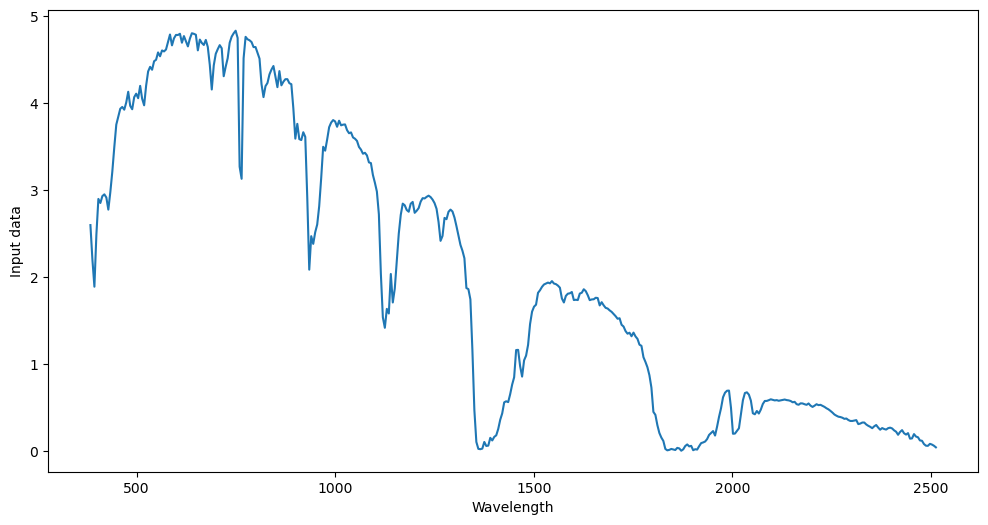

In [14]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(io.meas_wl, inp.meas)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Input data')

In [15]:
# Do the inversion!
states = iv.invert(inp.meas, inp.geom)

In [16]:
# Plot 
def closest_wl(mv):
    return np.argmin(np.abs(io.meas_wl-mv))

wl_nan = io.meas_wl.copy()
wl_nan[closest_wl(1360):closest_wl(1410)] = np.nan
wl_nan[closest_wl(1800):closest_wl(1970)] = np.nan

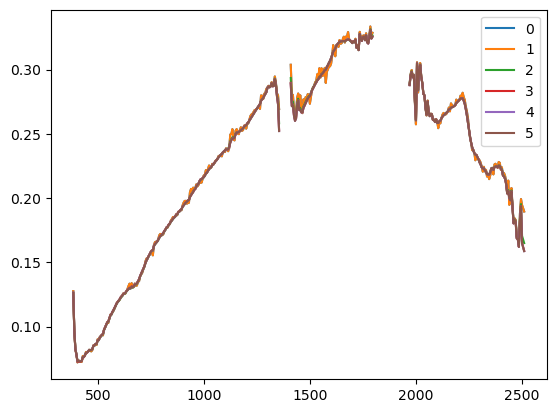

In [17]:
for n in range(states.shape[0]):
    plt.plot(wl_nan, states[n,:-2], label=f'{n}')
plt.legend()